In [1]:
import h5py
import tensorflow as tf
from keras import layers, models
import numpy as np


c:\Users\Raaghav\miniconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
encoder = tf.keras.models.load_model(
    "../models/vicreg_encoder.h5",
    compile=False
)


In [3]:
file = h5py.File("../data/Dataset_Specific_labelled.h5", "r")
X_ds = file["jet"]
Y_ds = file["Y"]

num_samples = len(Y_ds)
indices = np.arange(num_samples)

np.random.seed(42)
np.random.shuffle(indices)

split = int(0.8 * num_samples)
train_idx = indices[:split]
test_idx  = indices[split:]


In [4]:
def gen_labelled(indices):
    for i in indices:
        x = X_ds[i].astype("float16")   # memory efficient
        y = int(Y_ds[i])               # scalar label
        yield x, y

In [5]:
train_ds = tf.data.Dataset.from_generator(
    lambda: gen_labelled(train_idx),
    output_signature=(
        tf.TensorSpec(shape=(125, 125, 8), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

train_ds = train_ds.shuffle(512).batch(16).prefetch(tf.data.AUTOTUNE)


In [6]:
test_ds = tf.data.Dataset.from_generator(
    lambda: gen_labelled(test_idx),
    output_signature=(
        tf.TensorSpec(shape=(125, 125, 8), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

test_ds = test_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [7]:
def classifier(encoder):
    encoder.trainable = False
    input = encoder.input
    x = encoder.output
    x = layers.Dense(256,activation='relu',name = 'ci')(x)
    x = layers.Dense(128,activation='relu',name = 'cm')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1,activation = 'sigmoid', name = 'cf')(x)
    return models.Model(input,outputs)

In [8]:
def regression(encoder):
    encoder.trainable = False
    input = encoder.input
    x = encoder.output
    x = layers.Dense(256, activation='relu',name = 'ri')(x)
    x = layers.Dense(128,activation='relu',name = 'rm')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1,name = 'rf')(x)
    return models.Model(input, outputs)

In [9]:
clf_model = classifier(encoder)
clf_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)


In [10]:
reg_model = regression(encoder)
reg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)


In [11]:
# unfreeze last encoder layers
for layer in encoder.layers[-10:]:
    layer.trainable = True

# IMPORTANT: recompile FULL MODEL
clf_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

clf_model.fit(
    train_ds,
    epochs=20
)


Epoch 1/20


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


500/500 [==============================] - 207s 26ms/step - loss: 0.6443 - auc: 0.7770
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.4462 - auc: 0.8749
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3985 - auc: 0.9028
Epoch 4/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3468 - auc: 0.9262
Epoch 5/20
500/500 [==============================] - 13s 24ms/step - loss: 0.2959 - auc: 0.9471
Epoch 6/20
500/500 [==============================] - 14s 26ms/step - loss: 0.2347 - auc: 0.9662
Epoch 7/20
500/500 [==============================] - 13s 24ms/step - loss: 0.1715 - auc: 0.9816
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.1394 - auc: 0.9873
Epoch 9/20
500/500 [==============================] - 11s 20ms/step - loss: 0.0968 - auc: 0.9935
Epoch 10/20
500/500 [==============================] - 11s 20ms/step - loss: 0.0775 - auc: 0.9955
Epoch 11/20
500/500 [==================

In [12]:
for layer in encoder.layers[-10:]:
    layer.trainable = True

reg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

reg_model.fit(
    train_ds,
    epochs=20
)


Epoch 1/20


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


500/500 [==============================] - 11s 20ms/step - loss: 1.4019 - mae: 0.7718
Epoch 2/20
500/500 [==============================] - 11s 20ms/step - loss: 0.1203 - mae: 0.2659
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0667 - mae: 0.1960
Epoch 4/20
500/500 [==============================] - 11s 20ms/step - loss: 0.0519 - mae: 0.1657
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0443 - mae: 0.1493
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0390 - mae: 0.1362
Epoch 7/20
500/500 [==============================] - 11s 20ms/step - loss: 0.0348 - mae: 0.1248
Epoch 8/20
500/500 [==============================] - 11s 20ms/step - loss: 0.0307 - mae: 0.1175
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.0306 - mae: 0.1161
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.0274 - mae: 0.1108
Epoch 11/20
500/500 [===================

In [13]:
clf_model.trainable = False
clf_model.save("../models/classification_finetuned.h5")


In [14]:
reg_model.trainable = False
reg_model.save("../models/regression_finetuned.h5")


In [15]:
clf_model.predict(test_ds)

      6/Unknown - 0s 24ms/step

C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


125/125 [==============================] - 3s 24ms/step


array([[0.9998759 ],
       [0.02160846],
       [0.99748343],
       ...,
       [0.01619957],
       [0.9999652 ],
       [0.2747454 ]], dtype=float32)

In [16]:
reg_model.predict(test_ds)

     16/Unknown - 0s 12ms/step

C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


125/125 [==============================] - 1s 11ms/step


array([[1.0737557 ],
       [0.02974248],
       [0.9630258 ],
       ...,
       [0.03965624],
       [0.9215222 ],
       [0.05761275]], dtype=float32)

In [17]:
reg_model.evaluate(test_ds)


     11/Unknown - 0s 11ms/step - loss: 0.1402 - mae: 0.2093

C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


125/125 [==============================] - 2s 11ms/step - loss: 0.1501 - mae: 0.2127


[0.15013515949249268, 0.21265308558940887]

In [18]:
from sklearn.metrics import roc_curve, auc

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(clf_model.predict(x).ravel())

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)


1/1 [==============================] - 0s 139ms/step


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1/1 [==============================] - 0s 17ms/step


In [19]:
import matplotlib.pyplot as plt

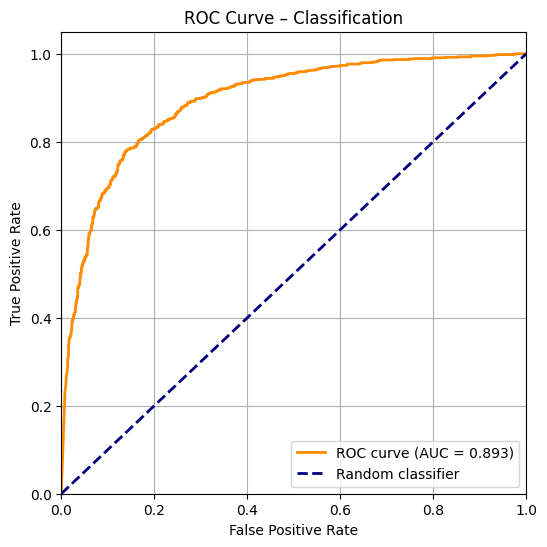

In [20]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange",
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 116ms/step


C:\Users\Raaghav\AppData\Local\Temp\ipykernel_22488\1642436263.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_ds[i])               # scalar label


1/1 [==============================] - 0s 14ms/step


Text(0.5, 1.0, 'True vs Predicted')

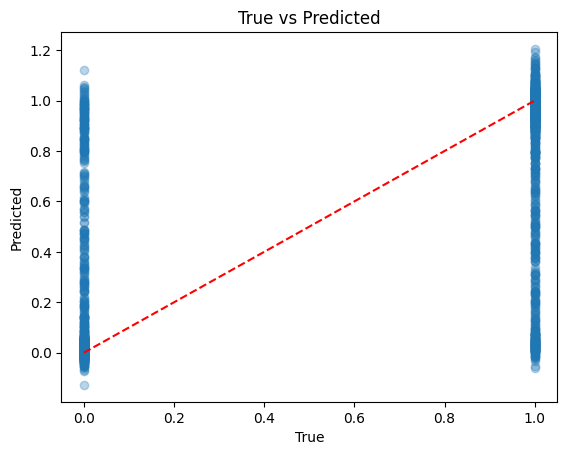

In [21]:

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(reg_model.predict(x).ravel())

plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted")


In [22]:
print("Unique Y values:", np.unique(Y_ds[:1000]))
print("Min Y:", Y_ds[:].min())
print("Max Y:", Y_ds[:].max())


Unique Y values: [0. 1.]
Min Y: 0.0
Max Y: 1.0


In [23]:
clf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 64)   25088       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [24]:
reg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 64)   25088       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            